In [35]:
import warnings
warnings.filterwarnings('ignore')

# necessary packages
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# additional certain short functions
from torch import is_tensor
from matplotlib.pyplot import pause
from random import randint
from copy import deepcopy
from math import floor, ceil
from torch import stack
from torch import cat

ground truth =  Bag
Dataset size =  60000


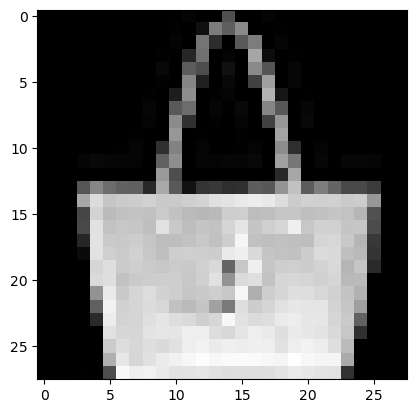

In [36]:
# get training dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# get testing dataset
testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# class names
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# print random item to visualize
rand = random.randint(0, 59999)
img = training_data.data[rand]
plt.imshow(img, cmap='gray')
print("ground truth = ", training_data.classes[training_data.targets[rand]])

# print dataset size 
size = len(training_data)
print("Dataset size = ", size)

In [101]:
# object picking
def pick(dataset: datasets, name: list, number: int) -> list:
    i = 0
    counter = [0] * len(name)
    score = []
    while True:
        if dataset.classes[dataset.targets[i]] in name and \
            counter[name.index(dataset.classes[dataset.targets[i]])] < number:
                if score == []:
                    score = dataset.data[i].reshape(1, 28, 28)
                else:
                    score = cat((score, dataset.data[i].reshape(1, 28, 28)), dim=0)
                counter[name.index(dataset.classes[dataset.targets[i]])] += 1
        i += 1
        correct = 0
        for j in range(len(name)):
            if counter[j] == number:
                correct += 1
        if correct == len(name):
            return score
        
# sequential album extension
def album(dataset: datasets, is_rand_pos: bool, is_rand_stride: bool) -> torch.Tensor:
    score = []
    # expand and clean
    for i in range(len(dataset)):
        if i == 0:
            score = dataset[i].repeat(3, 4).reshape(1, 28*3, 28*4)
        else:
            buffer = dataset[i].repeat(3, 4).reshape(1, 28*3, 28*4)
            score = cat((score, buffer), dim=0)
        score[i][:, 28:] = 0
        score[i][28:, :] = 0
    return score

torch.Size([28, 28])
True
torch.Size([84, 112])


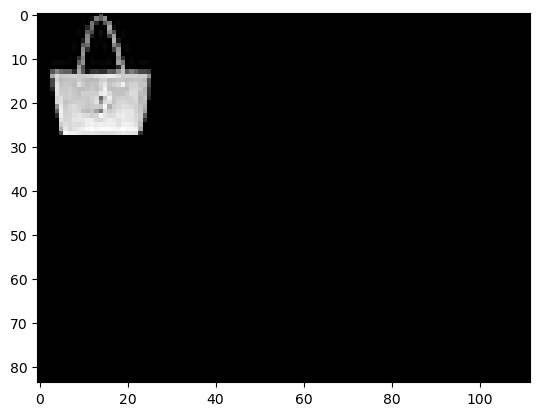

In [102]:
# from torch import is_tensor

# normalization
aug_sample = training_data.data[rand]/255.

# expand and clean
print(aug_sample.size())
aug_sample = aug_sample.repeat(3, 4)
aug_sample[:, 28:] = 0
aug_sample[28:, :] = 0

# print info
print(is_tensor(aug_sample))
print(aug_sample.size())
plt.imshow(aug_sample, cmap='gray')

6


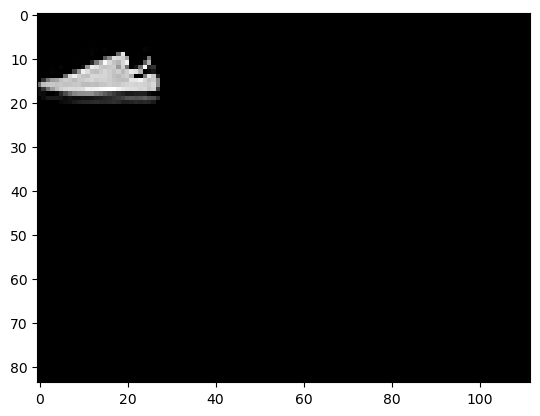

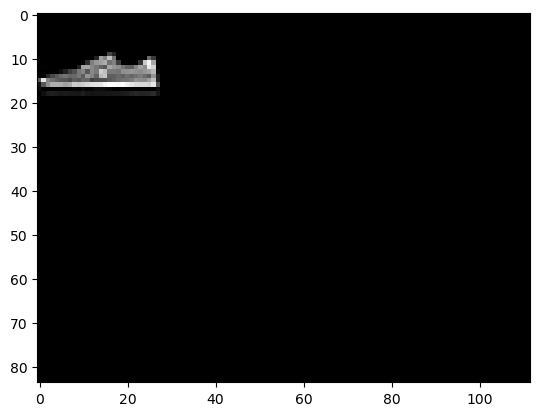

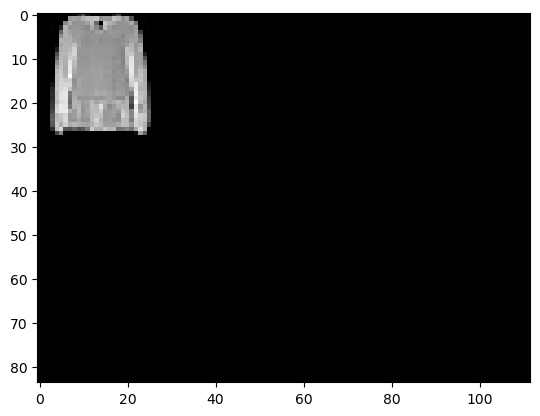

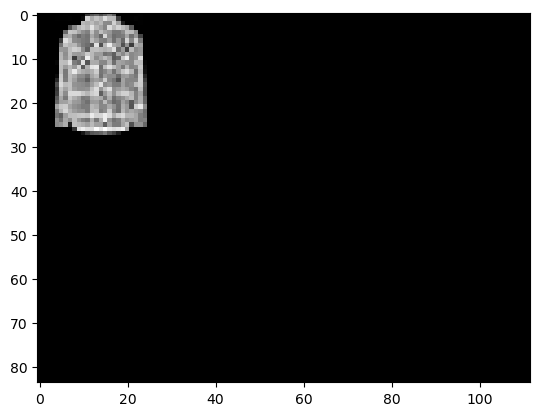

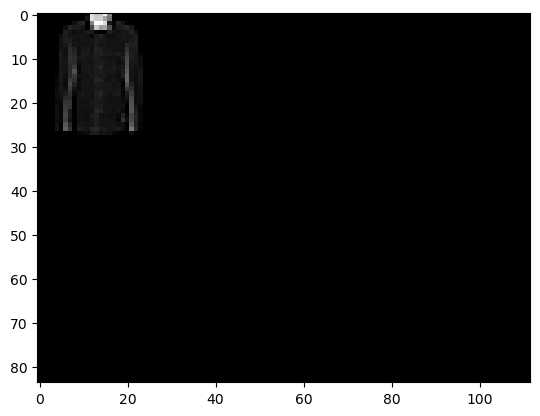

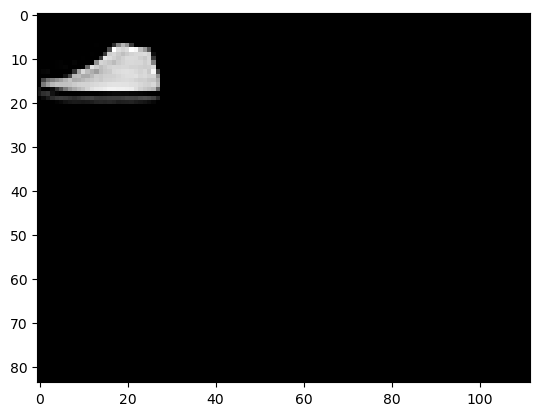

In [105]:
dataset = training_data
name = [
    "Shirt",
    "Sneaker",
]
number = 3

test = pick(dataset, name, number)
test = album(test, False, False)
print(len(test))

for i in range (number*len(name)):
    plt.imshow(test[i], cmap='gray')
    pause(0.1)

0
2020
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
